In [ ]:
# Imports and setups
!pip install kagglehub --quiet

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import cv2
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image


In [ ]:
import kagglehub

path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Dataset path:", path)

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Dataset path: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [ ]:
train_dir = f"{path}/train"
test_dir  = f"{path}/test"

In [ ]:
# =========================================================
# 3. Custom Dataset Class (using torchvision.io.read_image)
#     This is MUCH faster than Pillow
# =========================================================

class CIFAKEDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform

        real_dir = os.path.join(root_dir, "REAL")
        fake_dir = os.path.join(root_dir, "FAKE")

        for p in os.listdir(real_dir):
            self.paths.append(os.path.join(real_dir, p))
            self.labels.append(0)
        for p in os.listdir(fake_dir):
            self.paths.append(os.path.join(fake_dir, p))
            self.labels.append(1)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = read_image(img_path).float() / 255.0

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).float()

        return img, label


In [ ]:
# =========================================================
# 4. Transformations and DataLoaders
# =========================================================

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float32)
])

train_dataset = CIFAKEDataset(train_dir, transform)
test_dataset  = CIFAKEDataset(test_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Train samples: 100000
Test samples: 20000


In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# =========================================================
# 5. GPU-Based FFT and Sobel Filters (FAST)
# =========================================================

def extract_fft_gpu(img_batch):
    gray = img_batch.mean(dim=1, keepdim=True)  # [B,1,H,W]

    f = torch.fft.fftn(gray, dim=[2,3])
    fshift = torch.fft.fftshift(f, dim=[2,3])
    mag = torch.log(torch.abs(fshift) + 1e-8)

    return torch.stack([mag.mean(dim=[1,2,3]), mag.std(dim=[1,2,3])], dim=1)

def extract_edges_gpu(img_batch):
    # Convert batch to grayscale
    gray = img_batch.mean(dim=1, keepdim=True)  # [B,1,H,W]

    # Sobel kernels (float32)
    sobel_x = torch.tensor([[[-1., 0., 1.],
                             [-2., 0., 2.],
                             [-1., 0., 1.]]],
                           device=img_batch.device,
                           dtype=torch.float32).unsqueeze(1)

    sobel_y = torch.tensor([[[-1., -2., -1.],
                             [ 0.,  0.,  0.],
                             [ 1.,  2.,  1.]]],
                           device=img_batch.device,
                           dtype=torch.float32).unsqueeze(1)

    # Convolutions
    grad_x = torch.nn.functional.conv2d(gray, sobel_x, padding=1)
    grad_y = torch.nn.functional.conv2d(gray, sobel_y, padding=1)

    grad_mag = torch.sqrt(grad_x**2 + grad_y**2)

    # Edge features
    mean_edge = grad_mag.mean(dim=[1,2,3])
    std_edge  = grad_mag.std(dim=[1,2,3])
    edge_density = (grad_mag > grad_mag.mean()).float().mean(dim=[1,2,3])

    # Laplacian kernel (float32)
    lap_kernel = torch.tensor([[[0.,  1., 0.],
                                [1., -4., 1.],
                                [0.,  1., 0.]]],
                              device=img_batch.device,
                              dtype=torch.float32).unsqueeze(1)

    lap = torch.nn.functional.conv2d(gray, lap_kernel, padding=1)
    lap_var = lap.var(dim=[1,2,3])

    return torch.stack([mean_edge, std_edge, edge_density, lap_var], dim=1)


In [ ]:
# =========================================================
# 6. EfficientNet + FFT + Edge Hybrid Model
# =========================================================

def build_cnn():
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    model.classifier = nn.Identity()
    return model

class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = build_cnn()
        self.fc = nn.Sequential(
            nn.Linear(1280 + 2 + 4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, fft_feats, edge_feats):
        cnn_out = self.cnn(x)
        combined = torch.cat([cnn_out, fft_feats, edge_feats], dim=1)
        return self.fc(combined)


In [ ]:
# =========================================================
# 7. Train + Evaluate Loops
# =========================================================
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = HybridModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(loader):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)

        fft_feats = extract_fft_gpu(imgs)
        edge_feats = extract_edges_gpu(imgs)

        preds = model(imgs, fft_feats, edge_feats)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)

            fft_feats = extract_fft_gpu(imgs)
            edge_feats = extract_edges_gpu(imgs)

            preds = model(imgs, fft_feats, edge_feats)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, np.round(y_pred))
    auc = roc_auc_score(y_true, y_pred)

    return acc, auc

def evaluate_val(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.float().to(device).unsqueeze(1)

            fft = extract_fft_gpu(imgs)
            edges = extract_edges_gpu(imgs)

            outputs = model(imgs, fft, edges)

            # store
            y_true.extend(labels.cpu().numpy().flatten().tolist())
            y_pred.extend(outputs.cpu().numpy().flatten().tolist())

            # batch loss
            loss = nn.BCELoss()(outputs, labels)
            losses.append(loss.item())

    # convert lists to tensors properly (NO UNSQUEEZE)
    y_true_t = torch.tensor(y_true).float().unsqueeze(1)  # [N,1]
    y_pred_t = torch.tensor(y_pred).float().unsqueeze(1)  # [N,1]

    val_loss = nn.BCELoss()(y_pred_t, y_true_t).item()

    val_acc = accuracy_score((y_pred_t > 0.5).int(), y_true_t.int())
    val_auc = roc_auc_score(y_true, y_pred)

    return val_loss, val_acc, val_auc


In [ ]:
EPOCHS = 3

history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "val_auc": []
}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss = train_epoch(train_loader)
    val_loss, val_acc, val_auc = evaluate_val(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_auc"].append(val_auc)

    print(f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f} | Val AUC={val_auc:.4f}")

# =========================================================
# Save trained model
# =========================================================
save_path = "hybrid_cnn_fft_edges_cifake.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)



Epoch 1/3


Training: 100%|██████████| 2500/2500 [06:31<00:00,  6.39it/s]


Train Loss=0.1305 | Val Loss=0.0665 | Val Acc=0.9748 | Val AUC=0.9974

Epoch 2/3


Training: 100%|██████████| 2500/2500 [06:30<00:00,  6.40it/s]


Train Loss=0.0620 | Val Loss=0.0529 | Val Acc=0.9807 | Val AUC=0.9982

Epoch 3/3


Training: 100%|██████████| 2500/2500 [06:30<00:00,  6.40it/s]


Train Loss=0.0413 | Val Loss=0.0506 | Val Acc=0.9819 | Val AUC=0.9985
Model saved to: hybrid_cnn_fft_edges_cifake.pth


In [ ]:
loaded_model = HybridModel().to(device)
loaded_model.load_state_dict(torch.load(save_path, map_location=device))
loaded_model.eval()

print("Model loaded successfully.")

Model loaded successfully.


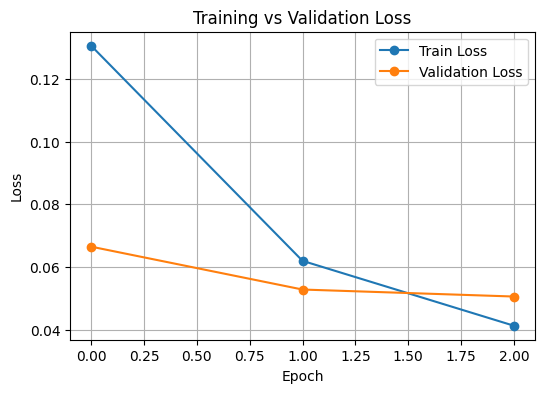

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'test_acc'

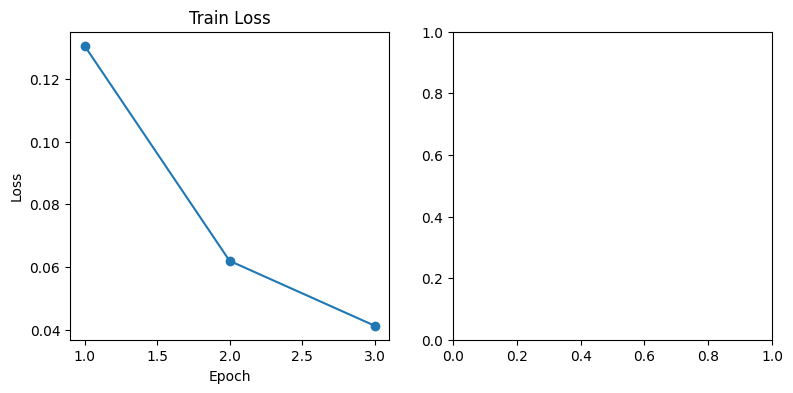

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(epochs, history["train_loss"], marker="o")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(epochs, history["test_acc"], marker="o")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,3,3)
plt.plot(epochs, history["test_auc"], marker="o")
plt.title("Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")

plt.tight_layout()
plt.show()


In [ ]:
from torch.nn import functional as F

class GradCAM:
    def __init__(self, model, target_layer_name="features.7"):
        self.model = model
        self.model.eval()

        self.gradients = None
        self.activations = None

        # get reference to the target layer
        self.target_layer = dict([*self.model.cnn.named_modules()])[target_layer_name]

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def forward_hook(module, inp, out):
            self.activations = out

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, img_tensor, fft_feats, edge_feats, index=None):
        self.model.zero_grad()

        output = self.model(img_tensor, fft_feats, edge_feats)
        if index is None:
            index = output.argmax(dim=1).item()

        target = output[0, index]
        target.backward()

        gradients = self.gradients[0]      # [C,H,W]
        activations = self.activations[0]  # [C,H,W]

        weights = gradients.mean(dim=(1,2))
        cam = torch.zeros(activations.shape[1:], device=img_tensor.device)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.detach().cpu().numpy()
        return cam


In [ ]:
class CNNOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = build_cnn()
        self.fc = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        cnn_out = self.cnn(x)
        return self.fc(cnn_out)

class FFTOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        return self.fc(fft_feats)

class EdgesOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        return self.fc(edge_feats)

class FFTPlusEdgesModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        feats = torch.cat([fft_feats, edge_feats], dim=1)
        return self.fc(feats)


In [ ]:
# # Main
# # Flow: main() -> train()/evaluate() -> extract_fft_features()/extract_edge_features() -> HybridModel.forward()
# # Note: train_dataset and test_dataset must be defined (from Cell 6) before calling main()
# def main():
#     print("Starting training...")

#     # Use the loaders you created above
#     # Assumes train_dataset and test_dataset are already loaded from Cell 6
#     train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
#     test_loader  = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False)

#     model = HybridModel().to(cfg.device)
#     optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
#     criterion = nn.BCELoss()

#     for epoch in range(cfg.num_epochs):
#         print(f"\nEpoch {epoch+1}/{cfg.num_epochs}")

#         loss = train(model, train_loader, optimizer, criterion)

#         acc, auc = evaluate(model, test_loader)

#         print(f"Loss={loss:.4f}  Acc={acc:.4f}  AUC={auc:.4f}")

# if __name__ == "__main__":
#   main()